#DT2470 Lab 02: Synchronization and rhythm

by Andre Holzapfel

In this lab you will choose to **either** do exercises regarding synchronization (chapter 3), **or** rhythm and tempo processing (chapter 6). We agree that doing both would be too much work (for this year), but you will have the code for the solutions for both anyway!

Again, you can use whatever software you want for your own implementation, but I use python in my explanations, and two external libraries in python need to be used in this Lab. Just as Bob, I am basically learning Python by working on this lab, so excuse my bad programming. (I am a bad programmer independent of language, anyway.)

Your task is to reproduce all shown figures with your code (or show the equivalent plots for your own audio files, if you use different ones). Also, provide short answers to the questions in the text.

##Audio samples:

In my examples I use file from the following google folder:

https://drive.google.com/drive/folders/1TGj4ZcEgdGXt9Eko2qViiiKWkUDDewbL?usp=sharing

You can copy these files to your own google folder and use them as explained in Lab 1.

At some points I will ask you to use some audio examples of your own. Be creative...the goal is to check where systems work or fail, and understand (to some extent) those behaviors.

## Code preparations

As for Lab 1, you need to have some external libraries also here:

In [0]:
# Install a python library for working with audio files, named pydub
!pip install pydub

In [0]:
# Other preparations!
import os, sys
from scipy import signal
import pydub
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# The following makes the plot look nice
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

### Google drive:

You need to adapt the following code to use the audio files that you copied to your google drive.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

root_path = 'gdrive/My Drive/KTH/DT2470/Lab_02/'

Mounted at /content/gdrive


# 1. Synchronisation

Complete the tasks in this part, if you want to focus on the synchronisation (but have a look at the rhythm part below before you decide!).

## Part 1.1 Warming up

Choose two music sound files that can be considered as interpretations of the same "tune". In my example I used the cmajor_piano.wav and Cmajor_sung.wav, where a C-major scale is performed, once on piano and once sung. For the beginning, choose some excerpts, and not complete pieces, in order to get started.

Read the sound files to a numpy array, and plot the two waveforms. (You did that in Lab 1 too).

Below the waveform I get for the piano file: ![waveform](https://drive.google.com/uc?id=1nt5lUZ1IWO8nWDx2mTdddz2pI9CuBfTq)


In [0]:
def sound_files_to_samples(filepath):
  sound = pydub.AudioSegment.from_file(filepath, format='wav')
  samples = np.array(sound.get_array_of_samples())  # Return the raw audio data as an array of (numeric) samples
  bit_width = sound.sample_width*8 # Number of bits in each sample
  normalized_samples = (samples/2**bit_width)*2  # Normalize the (bit_with)-bit track. Samples is now normalized [-1,1]

  fs = sound.frame_rate

  # If the audiofile has more than one channel work with the left one
  if sound.channels  > 1:
    samples_l = normalized_samples[::2]   # Left channel
    samples_r = normalized_samples[1::2]  # Right channel
    samples = samples_l                   # We look at left channel
  else:
    samples = normalized_samples
  return samples, fs, bit_width

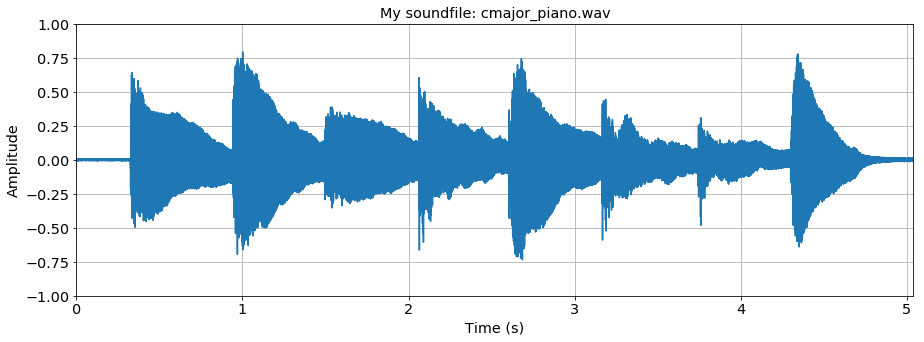

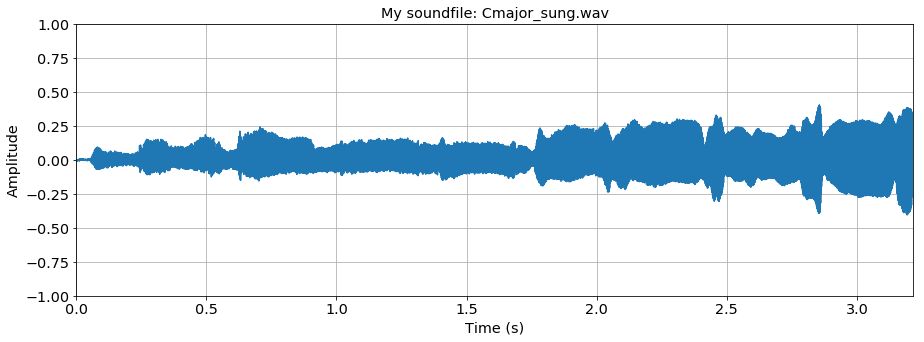

In [0]:
# Load sound samples
samples_piano, fs_piano, bitw_piano = sound_files_to_samples(root_path + '/data/cmajor_piano.wav')
samples_sung, fs_sung, bitw_sung = sound_files_to_samples(root_path + '/data/Cmajor_sung.wav')
time_piano = np.linspace(0, len(samples_piano)/fs_piano, num=len(samples_piano)) # Create x values for x axis
time_sung = np.linspace(0, len(samples_sung)/fs_sung, num=len(samples_sung)) # Create x values for x axis

# Plot and configure the first chart
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('My soundfile: cmajor_piano.wav')
plt.grid(True)
plt.xlim([0,len(samples_piano)/fs_piano]) # Set x axis range
plt.ylim([-1,1]) # Set y axis range
plt.plot(time_piano,samples_piano)
plt.show()

# Plot and configure the second chart
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('My soundfile: Cmajor_sung.wav')
plt.grid(True)
plt.xlim([0,len(samples_sung)/fs_sung]) # Set x axis range
plt.ylim([-1,1]) # Set y axis range
plt.plot(time_sung,samples_sung)
plt.show()

## Part 1.2 Compute the spectral magnitude

For both signals compute a Short-time Fourier transform (STFT), and plot their magnitude spectra (as in equation 3.1. Use the code from Lab 1 as starting point). Note: Since you are focusing on tonal content in the Chroma features, use a long window (about 100ms).

The magnitude spectrum for the piano example is shown below. 

Question: why do we see so few high-frequency components? (Hint: in lab 1 you plotted db magnitude spectra).

![](https://drive.google.com/uc?id=1_fEgRgIG0pPzCiNa6Pqz5lDfk-vfGloX)

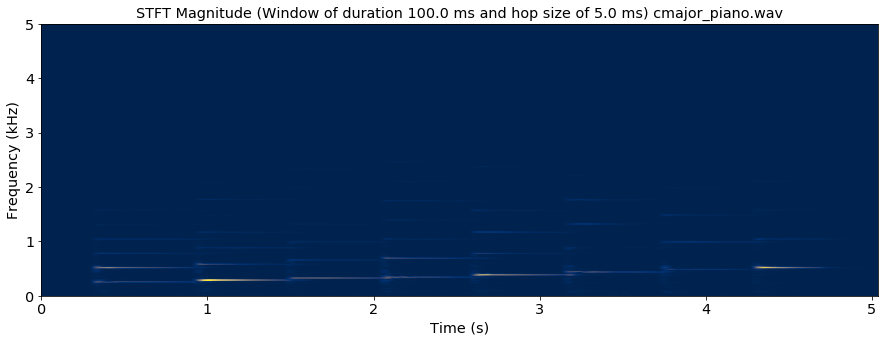

In [0]:
# STFT of the audio signal using window of duration 100 ms and a hopsize of 5 ms
window_size = 0.1 # Size of the window in seconds (in this case 100 ms)
hop_size = 0.005 # Size of the hopsize in seconds (in this case 5 ms)
f_piano, t_piano, samples_piano_stft = signal.stft(samples_piano, fs_piano, window='hann', nperseg=window_size*fs_piano, noverlap=((window_size-hop_size)*fs_piano)) # stft computing

abs_samples_piano_stft = np.abs(samples_piano_stft)
norm_samples_piano_stft = abs_samples_piano_stft/np.max(abs_samples_piano_stft)

plt.pcolormesh(t_piano, f_piano/1000, norm_samples_piano_stft, cmap=plt.cm.get_cmap('cividis'))
plt.title('STFT Magnitude (Window of duration ' + str(window_size*1000) + ' ms and hop size of ' + str(hop_size*1000) + ' ms) cmajor_piano.wav')
plt.ylabel('Frequency (kHz)')
plt.xlabel('Time (s)')
plt.ylim([0,5])
plt.show()

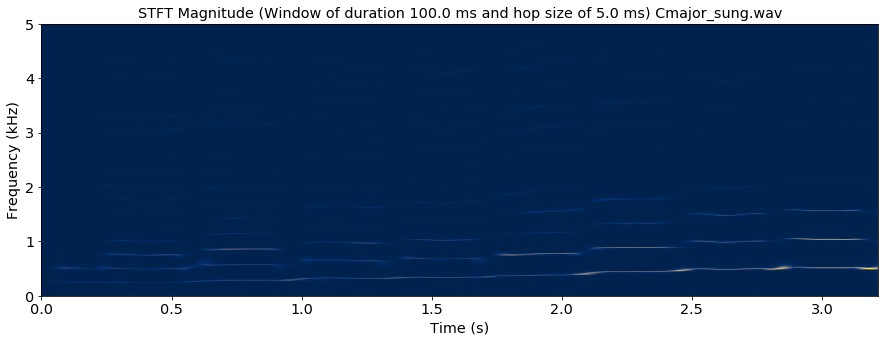

In [0]:
# STFT of the audio signal using window of duration 100 ms and a hopsize of 5 ms
window_size = 0.1 # Size of the window in seconds (in this case 100 ms)
hop_size = 0.005 # Size of the hopsize in seconds (in this case 5 ms) 
f_sung, t_sung, samples_sung_stft = signal.stft(samples_sung, fs_sung, window='hann', nperseg=window_size*fs_sung, noverlap=((window_size-hop_size)*fs_sung)) # stft computing

abs_samples_sung_stft = np.abs(samples_sung_stft)
norm_samples_sung_stft = abs_samples_sung_stft/np.max(abs_samples_sung_stft)

plt.pcolormesh(t_sung, f_sung/1000, norm_samples_sung_stft, cmap=plt.cm.get_cmap('cividis'))
plt.title('STFT Magnitude (Window of duration ' + str(window_size*1000) + ' ms and hop size of ' + str(hop_size*1000) + ' ms) Cmajor_sung.wav')
plt.ylabel('Frequency (kHz)')
plt.xlabel('Time (s)')
plt.ylim([0,5])
plt.show()

We can see only a few high frequency components because the differences in magnitude between low frequency and high frequency components are very large. If we want to enhance small sound components that may still be perceptually relevant, we could use a logarithmic scale. Below, the idea of compression is used in order to balance out this discrepancy by reducing the difference between large and small values with the effect of enhancing the small values.

## Part 1.3 Compute a log-frequency spectrogram

Now, transform the linear frequency axis into a logarithmic one (equation 3.4), and plot the resulting log-frequency spectra for both signals.

Hint: you need to assign the frequencies of the STFT coefficients to the desired pitch bins of the 12-tone resolution (equations 3.2 and 3.3, and the related text in the book help). Unless you are a good numpy programmer (I am not), you will need some loop in that code...

My piano log-f spectrogram looks as shown below.

Question: why do the low-frequency regions look so spread-out and smeary?

![](https://drive.google.com/uc?id=1pxHK7CVEX438DB4BAASGEiU3Qi-hw3Sc)



In [0]:
def frq2midi(freq):
  # Frequency (Hz) to MIDI pitch
  pitch = 12*(np.log2(freq)-np.log2(440))+69
  if isinstance(pitch,complex):
    pitch = np.nan
  else:
    pitch = np.round(pitch,0).astype(int)
  return pitch

def frq2midibins(freq,Zxx):
  pitch = frq2midi(freq)
  max_pitch = 127
  #max_pitch = max(pitch)
  bins = range(0,max_pitch+1)
  Ylf = np.zeros((max_pitch+1,np.size(Zxx,1)))
  for n in bins:
    #Ylf[n,:] = np.sum(np.abs(Zxx[np.where(pitch == n)]),axis=0)
    Ylf[n,:] = np.sum(np.power(np.abs(Zxx[np.where(pitch == n)]),2),axis=0)
  return bins, Ylf

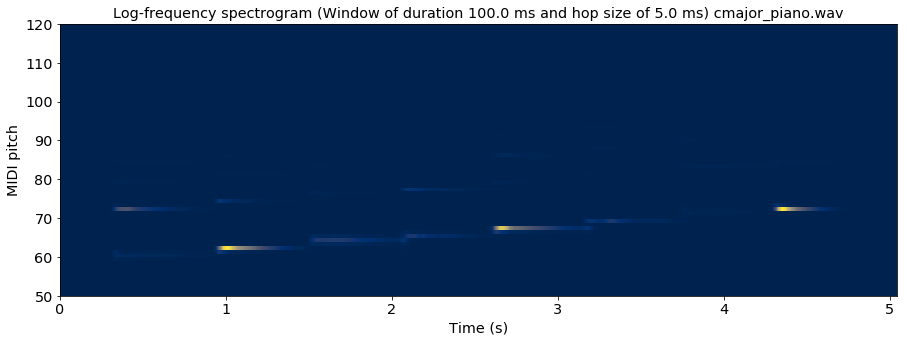

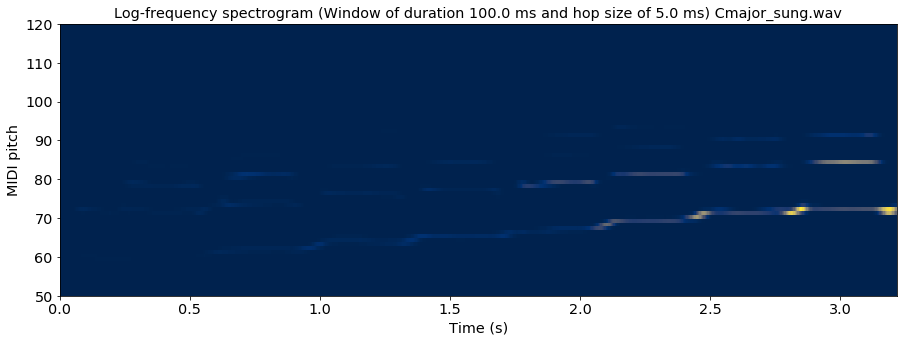

In [0]:
bins_piano,Ylf_piano = frq2midibins(f_piano[1:], samples_piano_stft[1:]); 
Ylf_piano_norm = Ylf_piano/np.max(Ylf_piano)

bins_sung,Ylf_sung = frq2midibins(f_sung[1:], samples_sung_stft[1:]);
Ylf_sung_norm = Ylf_sung/np.max(Ylf_sung)

# Plot piano Log-frequency spectogram
plt.pcolormesh(t_piano, bins_piano, Ylf_piano_norm, cmap=plt.cm.get_cmap('cividis'))
plt.title('Log-frequency spectrogram (Window of duration ' + str(window_size*1000) + ' ms and hop size of ' + str(hop_size*1000) + ' ms) cmajor_piano.wav')
plt.ylabel('MIDI pitch')
plt.xlabel('Time (s)')
plt.ylim([50,120])
plt.show()

# Plot sung Log-frequency spectogram
plt.pcolormesh(t_sung, bins_sung, Ylf_sung_norm, cmap=plt.cm.get_cmap('cividis'))
plt.title('Log-frequency spectrogram (Window of duration ' + str(window_size*1000) + ' ms and hop size of ' + str(hop_size*1000) + ' ms) Cmajor_sung.wav')
plt.ylabel('MIDI pitch')
plt.xlabel('Time (s)')
plt.ylim([50,120])
plt.show()

The spectogram of theC-major scale performed on piano shows that playing a single note on a real musical instrument can result in a complicated mix of distinct frequencies. The sounds for higher notes have a cleaner harmonic spectrum than those for lower notes as a general trend. Moreover, the energy of the signal is often contained in the higher harmonics for lower notes, while the listener may still have a low-pitched sound perception.

## Compute the chromagram

The chromagram is a feature that captures well harmonic and melodic development in a sound file. You will compute these features, to apply a synchronization (DTW) algorithm to them.



1.   Compute the chromagram according to equation 3.6

![](https://drive.google.com/uc?id=1Hj26wZ2WHufe1DkZqZoFrJ06kS7y8msS)

2.   Apply logarithmic compression to the chromagram. This will be your input feature for the DTW (my example uses gamma=100).

![](https://drive.google.com/uc?id=1eX8WhSmn6XxI8sIXxfRxdnssSrf2kICT)







In [0]:
def chromagram(Y_lf):
  max_pitch = 127;
  C_out = np.zeros((12,np.size(Y_lf,1)))
  for n in range(0,max_pitch+1):
    c = n%12
    for m in range(0,np.size(Y_lf,1)):
      C_out[c][m] += Y_lf[n][m]
  return C_out

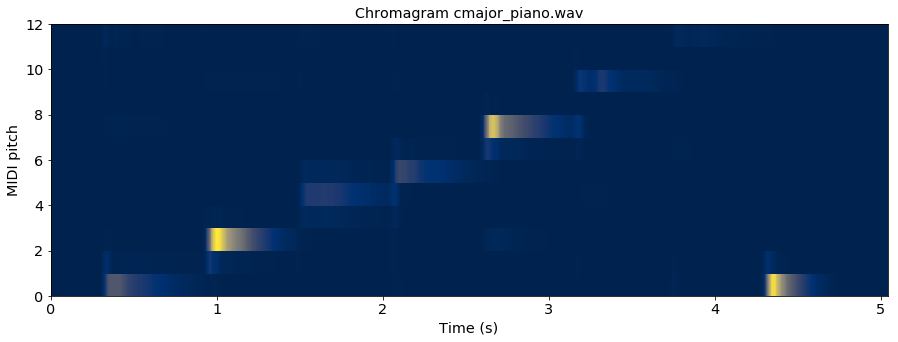

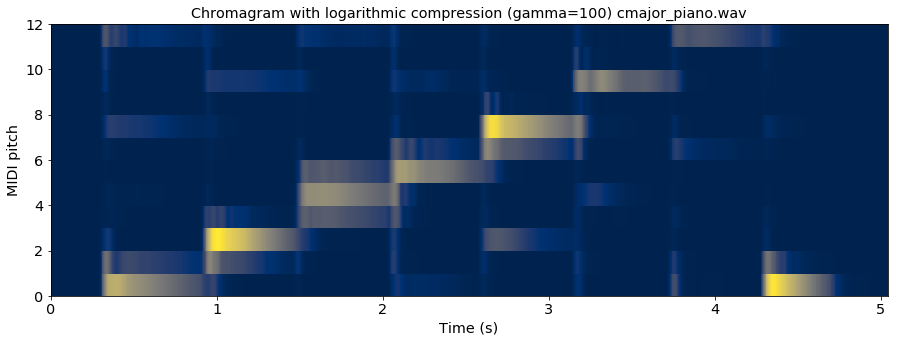

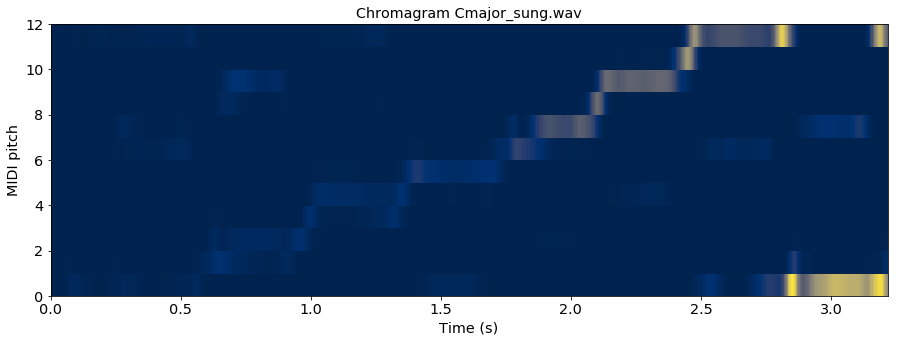

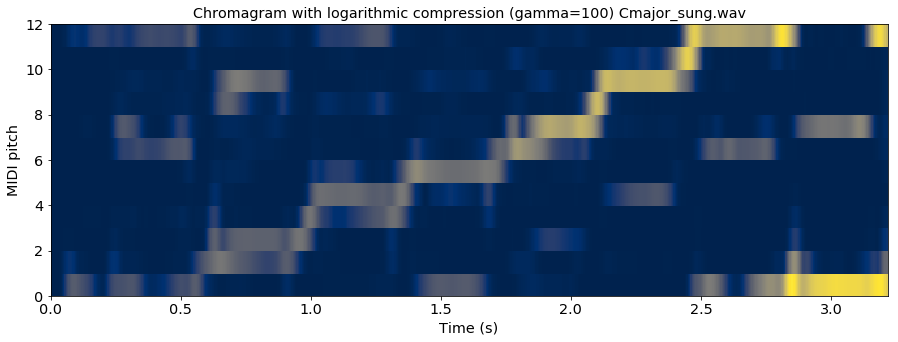

In [0]:
chromagram_scale = range(0,13)

# 1.Compute the chromagram according to equation 3.6
C_piano = chromagram(Ylf_piano_norm)
C_sung = chromagram(Ylf_sung_norm)

# 2.Apply logarithmic compression to the chromagram. This will be your input feature for the DTW (my example uses gamma=100).
gamma = 100
C_piano_logcomp = np.log(1+gamma*C_piano)
C_sung_logcomp = np.log(1+gamma*C_sung)

# Plot piano chromagram
plt.pcolormesh(t_piano, chromagram_scale, C_piano, cmap=plt.cm.get_cmap('cividis'))
plt.title('Chromagram cmajor_piano.wav')
plt.ylabel('MIDI pitch')
plt.xlabel('Time (s)')
plt.ylim([0,12])
plt.show()
# Plot piano chromagram with logarithmic compression
plt.pcolormesh(t_piano, chromagram_scale, C_piano_logcomp, cmap=plt.cm.get_cmap('cividis'))
plt.title('Chromagram with logarithmic compression (gamma=' + str(gamma) + ') cmajor_piano.wav')
plt.ylabel('MIDI pitch')
plt.xlabel('Time (s)')
plt.ylim([0,12])
plt.show()

# Plot sung chromagram
plt.pcolormesh(t_sung, chromagram_scale, C_sung, cmap=plt.cm.get_cmap('cividis'))
plt.title('Chromagram Cmajor_sung.wav')
plt.ylabel('MIDI pitch')
plt.xlabel('Time (s)')
plt.ylim([0,12])
plt.show()
# Plot sung chromagram with logarithmic compression 
plt.pcolormesh(t_sung, chromagram_scale, C_sung_logcomp, cmap=plt.cm.get_cmap('cividis'))
plt.title('Chromagram with logarithmic compression (gamma=' + str(gamma) + ') Cmajor_sung.wav')
plt.ylabel('MIDI pitch')
plt.xlabel('Time (s)')
plt.ylim([0,12])
plt.show()

## Part 1.4 Compute the synchronization

To this end, you will use the DTW as provided by the librosa library. You can see how to use it in the following code:

https://librosa.github.io/librosa_gallery/auto_examples/plot_music_sync

You can use your two computed chromagrams as inputs X and Y to this function, as they are. Compute the synchronization, and plot the path over the obtained cost matrix D.

The plot I obtain when synchronizing the piano and the voice example:

![](https://drive.google.com/uc?id=1RRtacUyBpbXQ8QMEgitRdSuLaH61MAGr)

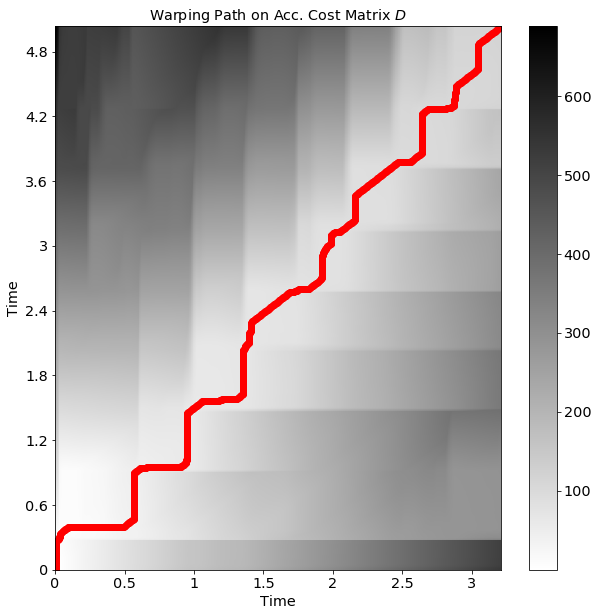

In [0]:
import librosa
import librosa.display
D, wp = librosa.core.dtw(X=C_piano_logcomp, Y=C_sung_logcomp, metric='cosine')
hop_size_n = ((hop_size)*fs_piano)
wp_s = np.asarray(wp) * hop_size_n / fs_piano


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
librosa.display.specshow(D, x_axis='time', y_axis='time',
                         cmap='gray_r', hop_length=hop_size_n/2)#note: a mystery to me, why I need to divide by 2...but I did not check their code.
imax = ax.imshow(D, cmap=plt.get_cmap('gray_r'),
                 origin='lower', interpolation='nearest', aspect='auto')
ax.plot(wp_s[:, 1], wp_s[:, 0], marker='o', color='r')
plt.title('Warping Path on Acc. Cost Matrix $D$')
plt.colorbar();

## Part 1.5 Compute the same alignment using the chroma features from librosa

OK, we went by the course book when computing the features above. Now let us use the librosa library, to compare with our implementation.

To this end, you can copy/paste and edit the code from the librosa example provided above, and compute the plots!

The chroma features look less noisy for me, probably because I used the logarithmic compression with a bad parameter. Note that the book says that all the parameters need to be adapted with care (which some people might call feature engineering):

![](https://drive.google.com/uc?id=1lxDS13V7f_azktMmJP5e9NUvQrp2KQ0c)

After that the warping path looks as follows for me:

![](https://drive.google.com/uc?id=1K5F9XnD6iyDudo1R9V4oCgmCYTqTzju8)

Finally, also compute the alignment visualization between the waveforms, as done in the librosa example. Mine looks as follows:

![](https://drive.google.com/uc?id=1feMM7D7w4uK3UajklQm849X3mDPtdkRU)



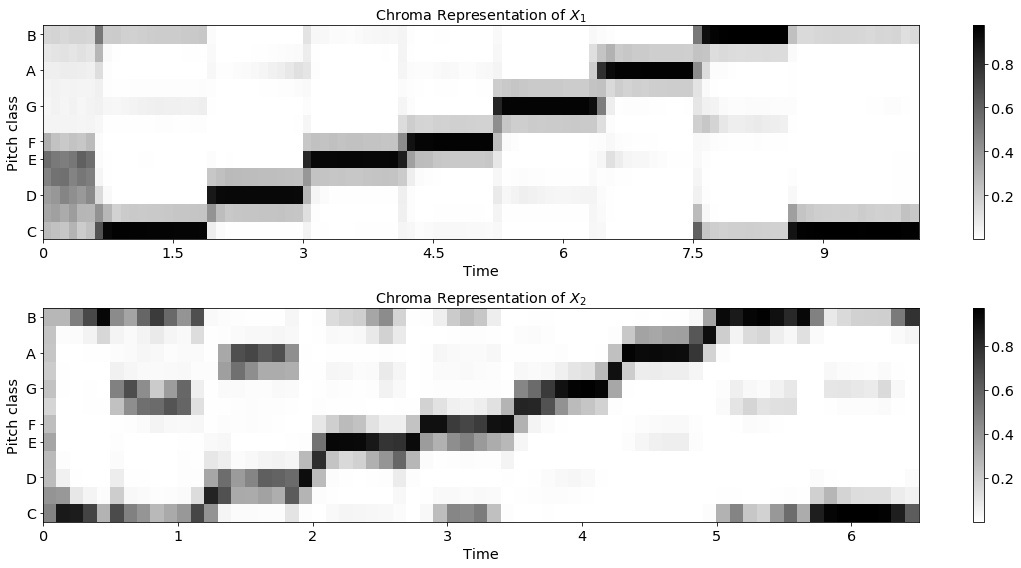

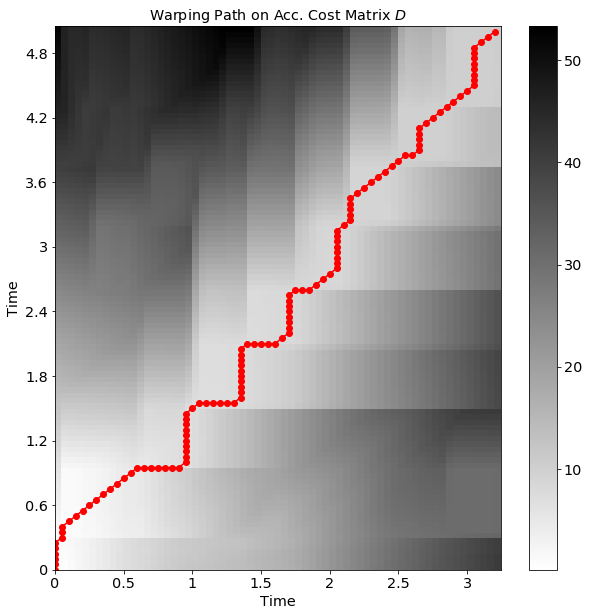

In [0]:
n_fft = 4410
hop_size = 2205
x_1, fs_x1= librosa.load(root_path + '/data/cmajor_piano.wav',sr=None)
x_2, fs_x2 = librosa.load(root_path + '/data/Cmajor_sung.wav',sr=None)
# Extract Chroma Features
x_1_chroma = librosa.feature.chroma_stft(y=x_1, sr=fs_x1, tuning=0, norm=2,
                                         hop_length=hop_size, n_fft=n_fft)
x_2_chroma = librosa.feature.chroma_stft(y=x_2, sr=fs_x2, tuning=0, norm=2,
                                         hop_length=hop_size, n_fft=n_fft)

plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
plt.title('Chroma Representation of $X_1$')
librosa.display.specshow(x_1_chroma, x_axis='time',
                         y_axis='chroma', cmap='gray_r', hop_length=hop_size)
plt.colorbar()
plt.subplot(2, 1, 2)
plt.title('Chroma Representation of $X_2$')
librosa.display.specshow(x_2_chroma, x_axis='time',
                         y_axis='chroma', cmap='gray_r', hop_length=hop_size)
plt.colorbar()
plt.tight_layout()

# Align Chroma Sequences
D, wp = librosa.core.dtw(X=x_1_chroma, Y=x_2_chroma, metric='cosine')
wp_s = np.asarray(wp) * hop_size / fs_x1

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
librosa.display.specshow(D, x_axis='time', y_axis='time',
                         cmap='gray_r', hop_length=hop_size/2)
imax = ax.imshow(D, cmap=plt.get_cmap('gray_r'),
                 origin='lower', interpolation='nearest', aspect='auto')
ax.plot(wp_s[:, 1], wp_s[:, 0], marker='o', color='r')
plt.title('Warping Path on Acc. Cost Matrix $D$')
plt.colorbar()

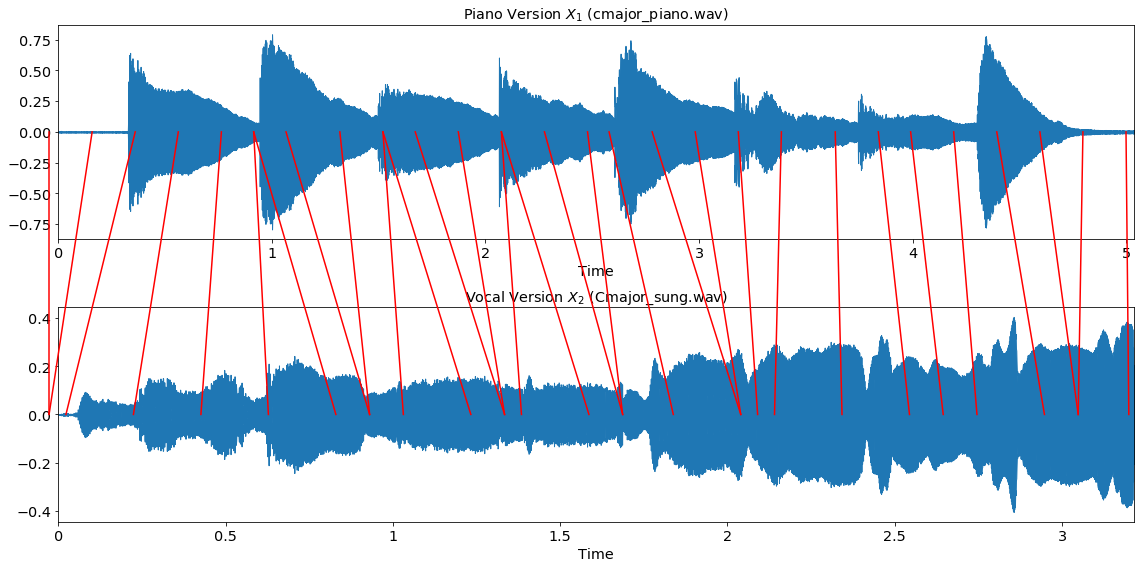

In [0]:
fig = plt.figure(figsize=(16, 8))

# Plot x_1
plt.subplot(2, 1, 1)
librosa.display.waveplot(x_1, sr=fs_piano)
plt.title('Piano Version $X_1$ (cmajor_piano.wav)')
ax1 = plt.gca()

# Plot x_2
plt.subplot(2, 1, 2)
librosa.display.waveplot(x_2, sr=fs_piano)
plt.title('Vocal Version $X_2$ (Cmajor_sung.wav)')
ax2 = plt.gca()

plt.tight_layout()

trans_figure = fig.transFigure.inverted()
lines = []
arrows = 30
points_idx = np.int16(np.round(np.linspace(0, wp.shape[0] - 1, arrows)))

# for tp1, tp2 in zip((wp[points_idx, 0]) * hop_size, (wp[points_idx, 1]) * hop_size):
for tp1, tp2 in wp[points_idx] * hop_size / fs_piano:
    # get position on axis for a given index-pair
    coord1 = trans_figure.transform(ax1.transData.transform([tp1, 0]))
    coord2 = trans_figure.transform(ax2.transData.transform([tp2, 0]))

    # draw a line
    line = matplotlib.lines.Line2D((coord1[0], coord2[0]),
                                   (coord1[1], coord2[1]),
                                   transform=fig.transFigure,
                                   color='r')
    lines.append(line)

fig.lines = lines
plt.tight_layout()

## Part 1.6 Last task: conclude, explore



1.   Compare the alignment obtained from "your" features with those using the librosa features, are they different? If yes, why do you think? \\

    As we can see in part 1.4 and 1.5 the alignment obtined from both features, even using the same hop size and n_fft, are different. I think that one of the main reasons might be the γ value since we are not able to know the γ chosen by the librosa library. Furthermore, the chromagram obtained with librosa it looks cleaner than the other one. Maybe they are applying some kind of morfological transformation or threshold to the chroma representation.

    Below there are some alignment tests with different gamma values.
    
    ![texto alternativo](https://drive.google.com/uc?export=view&id=1gVKPSr59oppXyAqqGhrAGqXQ1T8rFYYR)

2.   Replace the two simple sound files by two complete songs. You can use the Kafene1 and Kafene2 files in the shared folder, or some other song you like more. Compute the alignment, using the librosa features and provide a plot of the alignment curve. Did it work?

        As we can see below the alignment worked even with two complete songs.

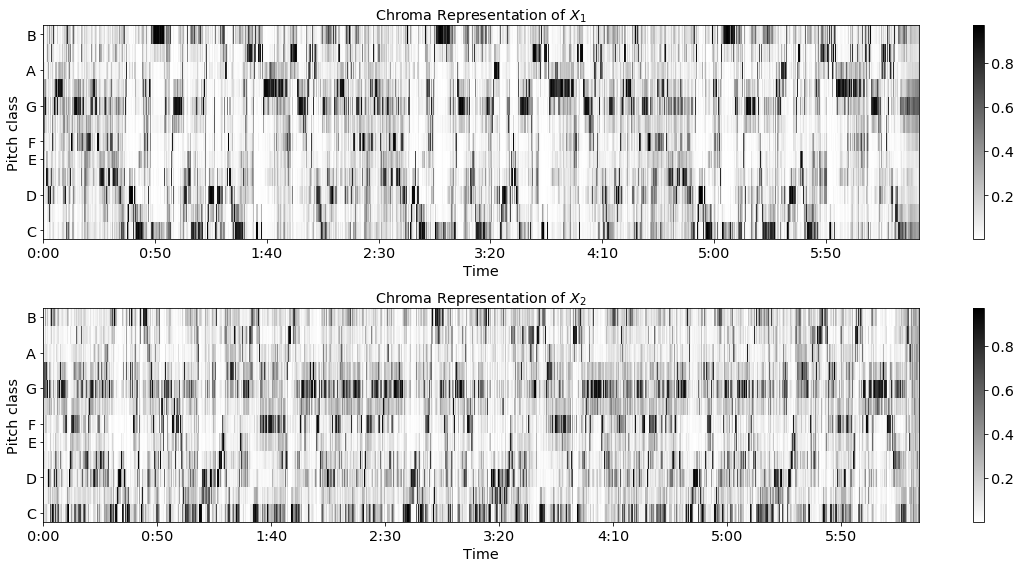

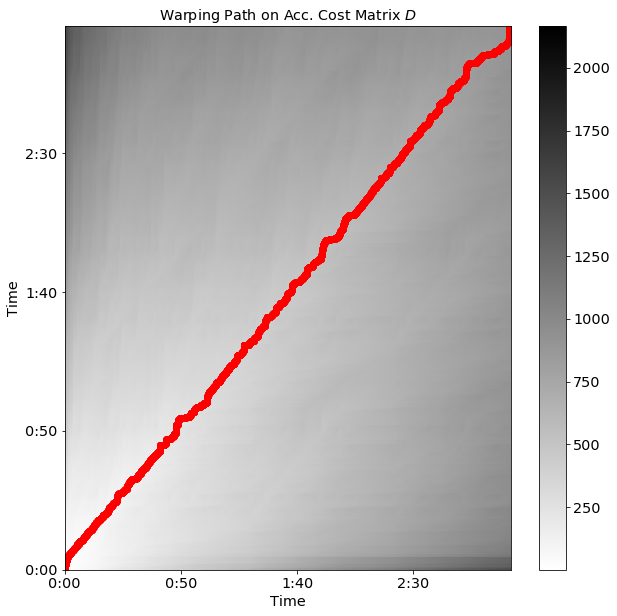

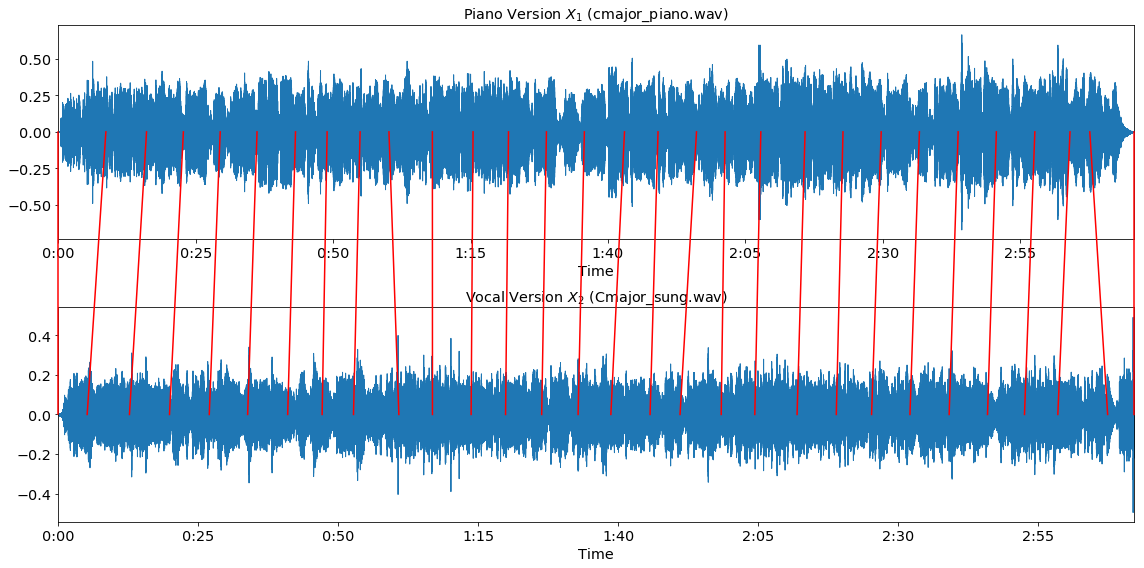

In [0]:
n_fft = 4410
hop_size = 2205
x_1, fs_x1 = librosa.load(root_path + '/data/Kafene1.wav',sr = None)
x_2, fs_x2 = librosa.load(root_path + '/data/Kafene2.wav',sr=None)
# Extract Chroma Features
x_1_chroma = librosa.feature.chroma_stft(y=x_1, sr=fs_x1, tuning=0, norm=2,
                                         hop_length=hop_size, n_fft=n_fft)
x_2_chroma = librosa.feature.chroma_stft(y=x_2, sr=fs_x2, tuning=0, norm=2,
                                         hop_length=hop_size, n_fft=n_fft)

plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
plt.title('Chroma Representation of $X_1$')
librosa.display.specshow(x_1_chroma, x_axis='time',
                         y_axis='chroma', cmap='gray_r', hop_length=hop_size)
plt.colorbar()
plt.subplot(2, 1, 2)
plt.title('Chroma Representation of $X_2$')
librosa.display.specshow(x_2_chroma, x_axis='time',
                         y_axis='chroma', cmap='gray_r', hop_length=hop_size)
plt.colorbar()
plt.tight_layout()

# Align Chroma Sequences
D, wp = librosa.core.dtw(X=x_1_chroma, Y=x_2_chroma, metric='cosine')
wp_s = np.asarray(wp) * hop_size / fs_x1

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
librosa.display.specshow(D, x_axis='time', y_axis='time',
                         cmap='gray_r', hop_length=hop_size/2)
imax = ax.imshow(D, cmap=plt.get_cmap('gray_r'),
                 origin='lower', interpolation='nearest', aspect='auto')
ax.plot(wp_s[:, 1], wp_s[:, 0], marker='o', color='r')
plt.title('Warping Path on Acc. Cost Matrix $D$')
plt.colorbar() 

fig = plt.figure(figsize=(16, 8))

# Plot x_1
plt.subplot(2, 1, 1)
librosa.display.waveplot(x_1, sr=fs_piano)
plt.title('Piano Version $X_1$ (cmajor_piano.wav)')
ax1 = plt.gca()

# Plot x_2
plt.subplot(2, 1, 2)
librosa.display.waveplot(x_2, sr=fs_piano)
plt.title('Vocal Version $X_2$ (Cmajor_sung.wav)')
ax2 = plt.gca()

plt.tight_layout()

trans_figure = fig.transFigure.inverted()
lines = []
arrows = 30
points_idx = np.int16(np.round(np.linspace(0, wp.shape[0] - 1, arrows)))

# for tp1, tp2 in zip((wp[points_idx, 0]) * hop_size, (wp[points_idx, 1]) * hop_size):
for tp1, tp2 in wp[points_idx] * hop_size / fs_piano:
    # get position on axis for a given index-pair
    coord1 = trans_figure.transform(ax1.transData.transform([tp1, 0]))
    coord2 = trans_figure.transform(ax2.transData.transform([tp2, 0]))

    # draw a line
    line = matplotlib.lines.Line2D((coord1[0], coord2[0]),
                                   (coord1[1], coord2[1]),
                                   transform=fig.transFigure,
                                   color='r')
    lines.append(line)

fig.lines = lines
plt.tight_layout()

3. Find two files where the alignment does not work, and explain why. Note: this can be e.g. because the two versions differ in form (e.g. Refrain repeated in one version), tuning, or instrumentation. Also: the chroma features work best for harmonic instruments, and for western-tonal music.

      After removing a couple of notes from the C-major scale sung, the algorithm it does not work because it is not able to detect that the notes missing are not in the other file and keeps trying to aling them with the C-major sacale performed on piano.

  ![texto alternativo](https://drive.google.com/uc?export=view&id=1Hk_mSgO1NiCcad1xT-W1QAXieTonmLxy)

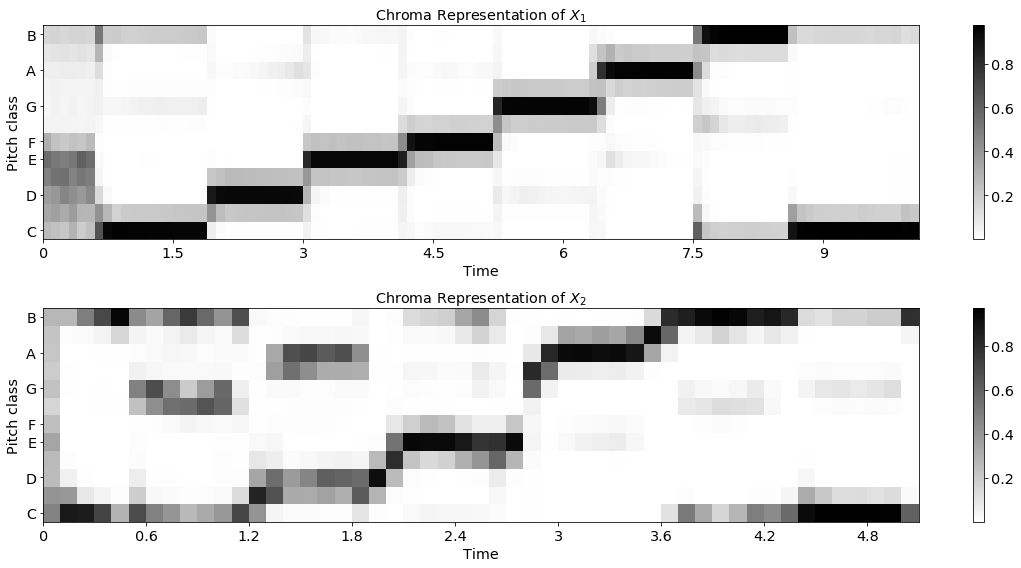

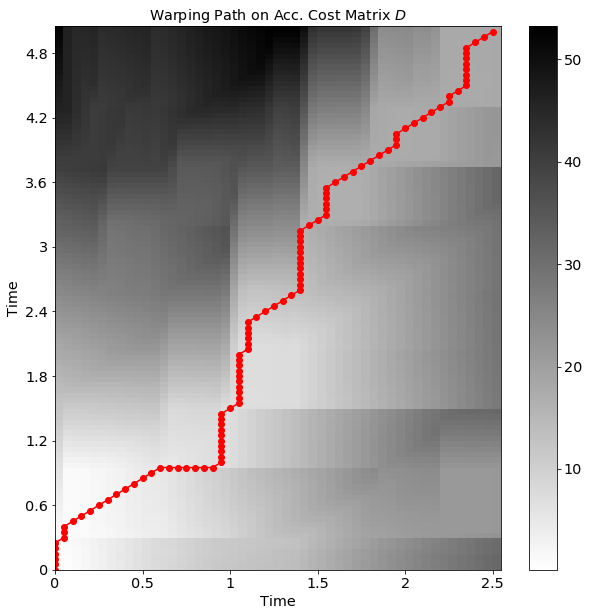

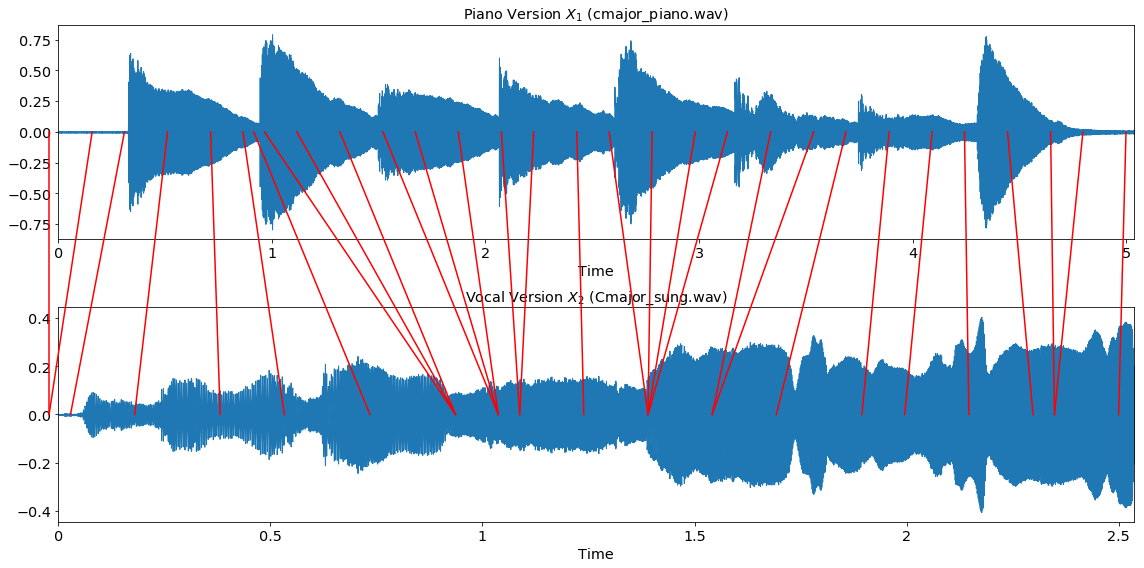

In [0]:
n_fft = 4410
hop_size = 2205
x_1, fs_x1= librosa.load(root_path + '/data/cmajor_piano.wav',sr=None)
x_2, fs_x2 = librosa.load(root_path + '/data/Cmajor_sung_cropped.wav',sr=None)

# Extract Chroma Features
x_1_chroma = librosa.feature.chroma_stft(y=x_1, sr=fs_x1, tuning=0, norm=2,
                                         hop_length=hop_size, n_fft=n_fft)
x_2_chroma = librosa.feature.chroma_stft(y=x_2, sr=fs_x2, tuning=0, norm=2,
                                         hop_length=hop_size, n_fft=n_fft)

plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
plt.title('Chroma Representation of $X_1$')
librosa.display.specshow(x_1_chroma, x_axis='time',
                         y_axis='chroma', cmap='gray_r', hop_length=hop_size)
plt.colorbar()
plt.subplot(2, 1, 2)
plt.title('Chroma Representation of $X_2$')
librosa.display.specshow(x_2_chroma, x_axis='time',
                         y_axis='chroma', cmap='gray_r', hop_length=hop_size)
plt.colorbar()
plt.tight_layout()

# Align Chroma Sequences
D, wp = librosa.core.dtw(X=x_1_chroma, Y=x_2_chroma, metric='cosine')
wp_s = np.asarray(wp) * hop_size / fs_x1

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
librosa.display.specshow(D, x_axis='time', y_axis='time',
                         cmap='gray_r', hop_length=hop_size/2)
imax = ax.imshow(D, cmap=plt.get_cmap('gray_r'),
                 origin='lower', interpolation='nearest', aspect='auto')
ax.plot(wp_s[:, 1], wp_s[:, 0], marker='o', color='r')
plt.title('Warping Path on Acc. Cost Matrix $D$')
plt.colorbar()

fig = plt.figure(figsize=(16, 8))

# Plot x_1
plt.subplot(2, 1, 1)
librosa.display.waveplot(x_1, sr=fs_piano)
plt.title('Piano Version $X_1$ (cmajor_piano.wav)')
ax1 = plt.gca()

# Plot x_2
plt.subplot(2, 1, 2)
librosa.display.waveplot(x_2, sr=fs_piano)
plt.title('Vocal Version $X_2$ (Cmajor_sung.wav)')
ax2 = plt.gca()

plt.tight_layout()

trans_figure = fig.transFigure.inverted()
lines = []
arrows = 30
points_idx = np.int16(np.round(np.linspace(0, wp.shape[0] - 1, arrows)))

# for tp1, tp2 in zip((wp[points_idx, 0]) * hop_size, (wp[points_idx, 1]) * hop_size):
for tp1, tp2 in wp[points_idx] * hop_size / fs_piano:
    # get position on axis for a given index-pair
    coord1 = trans_figure.transform(ax1.transData.transform([tp1, 0]))
    coord2 = trans_figure.transform(ax2.transData.transform([tp2, 0]))

    # draw a line
    line = matplotlib.lines.Line2D((coord1[0], coord2[0]),
                                   (coord1[1], coord2[1]),
                                   transform=fig.transFigure,
                                   color='r')
    lines.append(line)

fig.lines = lines
plt.tight_layout()